<a href="https://colab.research.google.com/github/chouhandiksha/bigdataproject/blob/colab/sketch/justin/SPARK_NY_CENSUS_Population_Density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load and display json map of chicago with d3
# Load population and cbg area
# Calculate density
# Draw density on the map

# Load social distancing Stay at home
# Display on map

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install geopandas

     |████████████████████████████████| 1.0MB 17.1MB/s 
     |████████████████████████████████| 6.5MB 30.8MB/s 
     |████████████████████████████████| 15.3MB 472kB/s 


In [4]:
import os
from tqdm.notebook import tqdm, trange

# Import modules
import geopandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

from IPython.display import display, HTML
import json

import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
# New York Counties
fips = ['36061','36047','36005','36085','36081']
f_string = " ( '36061','36047','36005','36085','36081' ) "

city_dir = 'ny'

source = Path('drive/MyDrive/big-data-project/data/unprocessed/census/safegraph_open_census_data/')
target = Path('drive/MyDrive/big-data-project/data/clean-data/')

**Spark SQL Documentation:** 
https://spark.apache.org/docs/2.2.0/sql-programming-guide.html

In [6]:
# Install required dependancies
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.3MB 64kB/s 
     |████████████████████████████████| 204kB 18.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=d5452dafeae83bab3288ee45a596f26cea4ab0a66f04458c5539a1efa8b3f361
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [7]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [8]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [9]:
!ls drive/MyDrive/big-data-project/data/unprocessed/census/safegraph_open_census_data/data/

cbg_b00.csv  cbg_b08.csv  cbg_b15.csv  cbg_b23.csv  cbg_c17.csv
cbg_b01.csv  cbg_b09.csv  cbg_b19.csv  cbg_b25.csv  cbg_c24.csv
cbg_b02.csv  cbg_b11.csv  cbg_b20.csv  cbg_b27.csv  cbg_patterns.csv
cbg_b03.csv  cbg_b12.csv  cbg_b21.csv  cbg_b99.csv
cbg_b07.csv  cbg_b14.csv  cbg_b22.csv  cbg_c16.csv


In [10]:
filepath = source/'metadata/cbg_geographic_data.csv'
df_meta = spark.read.format('csv').option('header','true').option('quote',"\"").option('escape',"\"").load(str(filepath))
df_meta.show()

+------------------+-----------+------------+----------+-----------+
|census_block_group|amount_land|amount_water|  latitude|  longitude|
+------------------+-----------+------------+----------+-----------+
|      010010201001|    4254524|       23431|32.4658291|-86.4896143|
|      010010201002|    5568295|           0|32.4858487|-86.4896898|
|      010010202001|    2058380|           0|32.4800823|-86.4749744|
|      010010202002|    1283506|        5968| 32.464435|-86.4697659|
|      010010203001|    3866515|        9054| 32.480175|-86.4607925|
|      010010203002|    1482758|           0|32.4643093|-86.4584716|
|      010010204001|    2730062|        1011|32.4851607|-86.4447716|
|      010010204002|    1782462|       15233|32.4704377|-86.4359688|
|      010010204003|     750824|           0|32.4632218|-86.4442795|
|      010010204004|    1119359|           0|32.4560697|-86.4417625|
|      010010205001|    4317356|           0|32.4460719| -86.418657|
|      010010205002|    5196333|  

In [11]:
df_meta.createOrReplaceTempView('T')
df_meta = spark.sql('SELECT * FROM T WHERE SUBSTRING(`census_block_group`,1,5) IN ' + f_string)
df_meta.show()

+------------------+-----------+------------+----------+-----------+
|census_block_group|amount_land|amount_water|  latitude|  longitude|
+------------------+-----------+------------+----------+-----------+
|      360050001000|          0|     1035011| 40.798169|-73.8916815|
|      360050001001|    1677210|           0|40.7911136|-73.8826858|
|      360050002000|          0|      852046|40.8035344|-73.8606612|
|      360050002001|      89013|           0|40.8139633|-73.8608664|
|      360050002002|     222104|           0|40.8116309|-73.8605956|
|      360050002003|     168346|           0|40.8081798|-73.8566782|
|      360050004000|          0|      685256|40.8034163|-73.8522258|
|      360050004001|      62874|           0|40.8139792|-73.8573467|
|      360050004002|     328785|        5538|40.8121666|-73.8523637|
|      360050004003|     294876|           0|40.8069355|-73.8520946|
|      360050004004|      84154|           0|40.8132154|-73.8480559|
|      360050016001|      77719|  

In [12]:
df_meta = df_meta.toPandas()
df_meta = df_meta.rename(columns={'census_block_group':'cbg'})
df_meta

,cbg,amount_land,amount_water,latitude,longitude
0,360050001000,0,1035011,40.798169,-73.8916815
1,360050001001,1677210,0,40.7911136,-73.8826858
2,360050002000,0,852046,40.8035344,-73.8606612
3,360050002001,89013,0,40.8139633,-73.8608664
4,360050002002,222104,0,40.8116309,-73.8605956
...,...,...,...,...,...
6488,360850319022,225236,0,40.6385202,-74.1670421
6489,360850319023,333435,0,40.6370862,-74.1629387
6490,360850323000,0,427143,40.6436495,-74.177242
6491,360850323001,3869216,35248,40.6369269,-74.1761443


In [13]:
filepath = source/'data/cbg_b01.csv'
df_pop = spark.read.format('csv').option('header','true').option('quote',"\"").option('escape',"\"").load(str(filepath))
df_pop.show()

+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+--------+

In [14]:
df_pop.createOrReplaceTempView('T')
df_pop = spark.sql('SELECT * FROM T WHERE SUBSTRING(`census_block_group`,1,5) IN ' + f_string)
df_pop.show()

+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+--------+

In [15]:
df_pop = df_pop.toPandas()
df_pop = df_pop[['census_block_group','B01003e1']]
df_pop = df_pop.rename(columns={'census_block_group':'cbg', 'B01003e1':'pop_total'})
df_pop

,cbg,pop_total
0,360050001000,0
1,360050001001,7503
2,360050002000,0
3,360050002001,2114
4,360050002002,2168
...,...,...
6488,360850319022,1293
6489,360850319023,1311
6490,360850323000,0
6491,360850323001,1218


In [16]:
df_merge = df_pop.merge(df_meta, how='inner', on='cbg')
df_merge

,cbg,pop_total,amount_land,amount_water,latitude,longitude
0,360050001000,0,0,1035011,40.798169,-73.8916815
1,360050001001,7503,1677210,0,40.7911136,-73.8826858
2,360050002000,0,0,852046,40.8035344,-73.8606612
3,360050002001,2114,89013,0,40.8139633,-73.8608664
4,360050002002,2168,222104,0,40.8116309,-73.8605956
...,...,...,...,...,...,...
6488,360850319022,1293,225236,0,40.6385202,-74.1670421
6489,360850319023,1311,333435,0,40.6370862,-74.1629387
6490,360850323000,0,0,427143,40.6436495,-74.177242
6491,360850323001,1218,3869216,35248,40.6369269,-74.1761443


In [17]:
df_merge['person_per_sq_meter'] = np.where((df_merge['amount_land'].to_numpy(dtype=np.float32) != 0.0) & (df_merge['pop_total'].to_numpy(dtype=np.float32) != 0.0), 
         df_merge['pop_total'].to_numpy(dtype=np.float32) / df_merge['amount_land'].to_numpy(dtype=np.float32),
         0.0)
df_merge.sort_values(by='person_per_sq_meter')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


,cbg,pop_total,amount_land,amount_water,latitude,longitude,person_per_sq_meter
0,360050001000,0,0,1035011,40.798169,-73.8916815,0.000000
3490,360610069000,0,0,272741,40.7307945,-74.0163727,0.000000
3452,360610062000,0,0,862281,40.7364871,-73.9674406,0.000000
3445,360610060000,0,0,300815,40.7311706,-73.9677779,0.000000
3415,360610048007,0,24000,0,40.7336477,-73.9839965,0.000000
...,...,...,...,...,...,...,...
3475,360610066005,2652,17036,0,40.7393326,-73.9813156,0.155670
3777,360610138002,2765,17459,0,40.775446,-73.9549809,0.158371
3885,360610156014,2763,15307,0,40.7842946,-73.9482507,0.180506
297,360050147023,2401,12650,0,40.8363414,-73.9063825,0.189802


In [18]:
df_merge = df_merge.set_index('cbg')
df_merge

,pop_total,amount_land,amount_water,latitude,longitude,person_per_sq_meter
cbg,,,,,,
360050001000,0,0,1035011,40.798169,-73.8916815,0.000000
360050001001,7503,1677210,0,40.7911136,-73.8826858,0.004474
360050002000,0,0,852046,40.8035344,-73.8606612,0.000000
360050002001,2114,89013,0,40.8139633,-73.8608664,0.023749
360050002002,2168,222104,0,40.8116309,-73.8605956,0.009761
...,...,...,...,...,...,...
360850319022,1293,225236,0,40.6385202,-74.1670421,0.005741
360850319023,1311,333435,0,40.6370862,-74.1629387,0.003932
360850323000,0,0,427143,40.6436495,-74.177242,0.000000


In [36]:
!ls drive/MyDrive/big-data-project/data/clean-data/ny/

ny_census.geojson  ny-covid.csv  ny.csv  ny.geojson  social


In [37]:
# Read geojson file
gdf = geopandas.read_file('drive/MyDrive/big-data-project/data/clean-data/{}/{}.geojson'.format(city_dir,city_dir))
gdf

,StateFIPS,CountyFIPS,TractCode,BlockGroup,CensusBlockGroup,State,County,ClassCode,geometry
0,36,005,017500,2,360050175002,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91570 40.83054, -73.91485 ..."
1,36,005,014100,1,360050141001,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91661 40.82499, -73.91592 ..."
2,36,005,014500,1,360050145001,NY,Bronx County,H6,"MULTIPOLYGON (((-73.90584 40.83106, -73.90505 ..."
3,36,005,007500,2,360050075002,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91035 40.81995, -73.91022 ..."
4,36,005,041800,1,360050418001,NY,Bronx County,H6,"MULTIPOLYGON (((-73.86287 40.89515, -73.86146 ..."
...,...,...,...,...,...,...,...,...,...
6488,36,085,004000,3,360850040003,NY,Richmond County,H6,"MULTIPOLYGON (((-74.08465 40.61520, -74.08405 ..."
6489,36,085,004000,5,360850040005,NY,Richmond County,H6,"MULTIPOLYGON (((-74.08103 40.61328, -74.08056 ..."
6490,36,085,007000,0,360850070000,NY,Richmond County,H6,"MULTIPOLYGON (((-74.07382 40.58045, -74.06953 ..."
6491,36,085,007400,0,360850074000,NY,Richmond County,H6,"MULTIPOLYGON (((-74.06180 40.59235, -74.05969 ..."


In [38]:
# simplify column name
gdf = gdf.rename(columns={'CensusBlockGroup':'cbg'})
gdf

,StateFIPS,CountyFIPS,TractCode,BlockGroup,cbg,State,County,ClassCode,geometry
0,36,005,017500,2,360050175002,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91570 40.83054, -73.91485 ..."
1,36,005,014100,1,360050141001,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91661 40.82499, -73.91592 ..."
2,36,005,014500,1,360050145001,NY,Bronx County,H6,"MULTIPOLYGON (((-73.90584 40.83106, -73.90505 ..."
3,36,005,007500,2,360050075002,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91035 40.81995, -73.91022 ..."
4,36,005,041800,1,360050418001,NY,Bronx County,H6,"MULTIPOLYGON (((-73.86287 40.89515, -73.86146 ..."
...,...,...,...,...,...,...,...,...,...
6488,36,085,004000,3,360850040003,NY,Richmond County,H6,"MULTIPOLYGON (((-74.08465 40.61520, -74.08405 ..."
6489,36,085,004000,5,360850040005,NY,Richmond County,H6,"MULTIPOLYGON (((-74.08103 40.61328, -74.08056 ..."
6490,36,085,007000,0,360850070000,NY,Richmond County,H6,"MULTIPOLYGON (((-74.07382 40.58045, -74.06953 ..."
6491,36,085,007400,0,360850074000,NY,Richmond County,H6,"MULTIPOLYGON (((-74.06180 40.59235, -74.05969 ..."


In [39]:
# set index for join
gdf = gdf.set_index('cbg')
gdf

,StateFIPS,CountyFIPS,TractCode,BlockGroup,State,County,ClassCode,geometry
cbg,,,,,,,,
360050175002,36,005,017500,2,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91570 40.83054, -73.91485 ..."
360050141001,36,005,014100,1,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91661 40.82499, -73.91592 ..."
360050145001,36,005,014500,1,NY,Bronx County,H6,"MULTIPOLYGON (((-73.90584 40.83106, -73.90505 ..."
360050075002,36,005,007500,2,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91035 40.81995, -73.91022 ..."
360050418001,36,005,041800,1,NY,Bronx County,H6,"MULTIPOLYGON (((-73.86287 40.89515, -73.86146 ..."
...,...,...,...,...,...,...,...,...
360850040003,36,085,004000,3,NY,Richmond County,H6,"MULTIPOLYGON (((-74.08465 40.61520, -74.08405 ..."
360850040005,36,085,004000,5,NY,Richmond County,H6,"MULTIPOLYGON (((-74.08103 40.61328, -74.08056 ..."
360850070000,36,085,007000,0,NY,Richmond County,H6,"MULTIPOLYGON (((-74.07382 40.58045, -74.06953 ..."


In [40]:
gdf = gdf.merge(df_merge, left_index=True, right_index=True)
gdf

,StateFIPS,CountyFIPS,TractCode,BlockGroup,State,County,ClassCode,geometry,pop_total,amount_land,amount_water,latitude,longitude,person_per_sq_meter
cbg,,,,,,,,,,,,,,
360050175002,36,005,017500,2,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91570 40.83054, -73.91485 ...",1110,23694,0,40.8296335,-73.9152037,0.046847
360050141001,36,005,014100,1,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91661 40.82499, -73.91592 ...",1445,55934,0,40.8245444,-73.9131209,0.025834
360050145001,36,005,014500,1,NY,Bronx County,H6,"MULTIPOLYGON (((-73.90584 40.83106, -73.90505 ...",2003,47026,0,40.8309816,-73.905087,0.042593
360050075002,36,005,007500,2,NY,Bronx County,H6,"MULTIPOLYGON (((-73.91035 40.81995, -73.91022 ...",2731,109058,0,40.8202395,-73.9080678,0.025042
360050418001,36,005,041800,1,NY,Bronx County,H6,"MULTIPOLYGON (((-73.86287 40.89515, -73.86146 ...",936,140793,0,40.8989195,-73.8564428,0.006648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360850040003,36,085,004000,3,NY,Richmond County,H6,"MULTIPOLYGON (((-74.08465 40.61520, -74.08405 ...",2757,75183,0,40.6154497,-74.0827729,0.036671
360850040005,36,085,004000,5,NY,Richmond County,H6,"MULTIPOLYGON (((-74.08103 40.61328, -74.08056 ...",948,66995,0,40.613997,-74.0792571,0.014150
360850070000,36,085,007000,0,NY,Richmond County,H6,"MULTIPOLYGON (((-74.07382 40.58045, -74.06953 ...",0,0,866081,40.5821041,-74.0677399,0.000000


In [41]:
maxs = gdf['person_per_sq_meter'].max()
mins = gdf['person_per_sq_meter'].min()
print(maxs)
print(mins)

0.2174759954214096
0.0


In [42]:
gdf['person_per_sq_meter_sqrt'] = np.sqrt(gdf['person_per_sq_meter'])

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

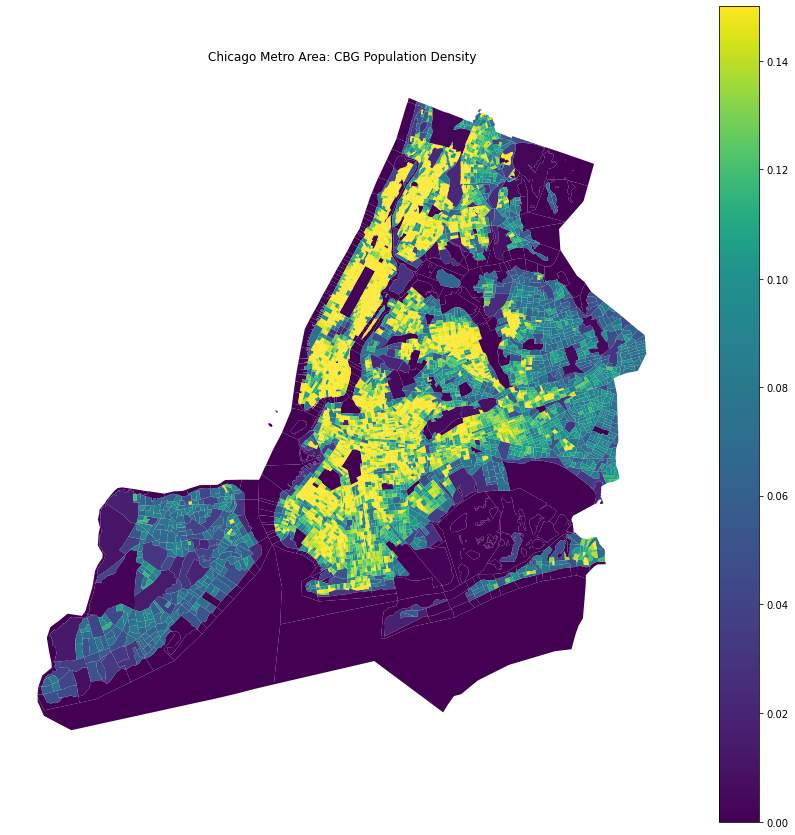

In [44]:
import matplotlib
# Plot density

# fig, ax = plt.subplots()
midnorm = MidpointNormalize(vmin=0., vcenter=0.1, vmax=0.15)

fig, ax = plt.subplots(figsize = (15,15))
ax.title.set_text('Chicago Metro Area: CBG Population Density')
ax.axis('off')
# gdf.plot(column='person_per_sq_meter', ax=ax, legend=True);
gdf.plot(column='person_per_sq_meter_sqrt', ax=ax, legend=True, norm=midnorm);

In [45]:
!pip install geoplot



In [46]:
import geoplot as gplt

import geoplot.crs as gcrs

In [47]:
!ls drive/MyDrive/big-data-project/sketch/justin/

ch.geojson		    la_social_summary_2019.csv
ch_social_summary_2019.csv  la-time
ch-time			    movies
ch_time_data.csv	    ny_social_summary_2019.csv
ch_time.geojson		    ny-time


In [48]:
gdf.to_file("drive/MyDrive/big-data-project/sketch/justin/{}.geojson".format(city_dir), driver='GeoJSON')

In [ ]:
# pip install keplergl